# ConvNeXt on FashionMNIST

## Setup

In [6]:
import torch
import torch.nn as nn
import timm
import timm.data
import semitorch
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc
import numpy as np
from IPython import display
from tqdm.notebook import tqdm, trange

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device = {device}")

convnext_st_classic_atto = timm.create_model(
    "convnext_st_classic_atto", in_chans=1, stem_patch_size=1
)
convnext_st_classic_atto = convnext_st_classic_atto.to(device)

num_params = sum(
    p.numel() for p in convnext_st_classic_atto.parameters() if p.requires_grad
)
print(f"convnext_st_classic_atto has {num_params:,} parameters")

device = cuda
convnext_st_classic_atto has 3,700,160 parameters


In [7]:
# Load FashionMNIST dataset
batch_size = 256
num_workers = 8

transforms_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.286,),(0.353,)),
        #transforms.RandomCrop((24, 24)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.286,),(0.353,)),
    ]
)

trainset = FashionMNIST(root=".", train=True, download=True, transform=transforms_train)
testset = FashionMNIST(root=".", train=False, download=True, transform=transforms_test)

trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)



## Training

We train the network with SGD+momentum under the [one cycle policy](https://arxiv.org/abs/1708.07120).
As usual we use cross entropy loss.
To track the track the training process we plot the accuracy of each training batch as a blue dot, every epoch we also test the network and the training data and plot the network's accuracy as an orange line.

In [8]:
def accuracy(model, x, y):
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)
        return (y==prediction).sum().item() / float(y.numel())



def test(model, device, testloader):
    model.eval()
    accs = []
    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))
    return sum(accs)/len(accs)


def train(model, device, trainloader, testloader, optimizer, scheduler, loss, epochs):
    accs = [] # list of accuracy on the test dataset for every epoch
    trainaccs = [] # a list of the accuracies of all the training batches

    fig, ax = plt.subplots(1, 1, figsize=[6,4])
    hdisplay = display.display("", display_id=True)

    for epoch in trange(epochs):
        model.train()
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu()==prediction).sum().item() / float(y.numel()))
            l = loss(yout, y)
            l.backward()
            optimizer.step()
            scheduler.step()

        accs.append(test(model, device, testloader))

        ax.clear()
        ax.set_xlim(0, epochs)
        ax.set_ylim(0.75, 1.0)
        ax.plot(np.linspace(0,len(accs),len(trainaccs)), 
            trainaccs, ".", markersize=1.5, markerfacecolor=(0, 0, 1, 0.3))
        ax.plot(np.linspace(1,len(accs),len(accs)), accs)
        ax.text(0.6*epochs, 0.80, f"max test acc = {max(accs):.2%}", ha="center", fontsize=10)
        hdisplay.update(fig)
        
        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    plt.close(fig)
        

def resetmodel(model: nn.Module) -> None:
    @torch.no_grad()
    def weight_reset(m: nn.Module):
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()
    model.apply(fn=weight_reset)

In [9]:
convnext_st_classic_atto.reset_parameters()

''

  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

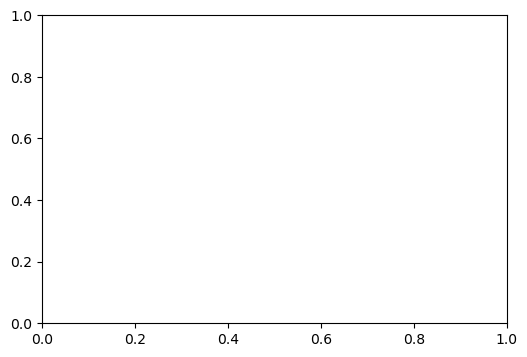

In [10]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
epochs = 40

optimizer = torch.optim.SGD(convnext_st_classic_atto.parameters(), 
                lr=1.0e-3,
                momentum=0.9,
                weight_decay=1e-4
            )
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                max_lr=1.0e-3,
                anneal_strategy='linear',
                pct_start=0.4,
                three_phase=True,
                final_div_factor=500.0,
                div_factor=25.0,
                steps_per_epoch=len(trainloader), 
                epochs=epochs
            )

train(convnext_st_classic_atto, device, trainloader, testloader, optimizer, scheduler, loss, epochs)

In [ ]:
# save layer names
layer_names = []
for idx, (name, param) in enumerate(convnext_st_classic_atto.named_parameters()):
    layer_names.append(name)
    print(f'{idx}: {name}')

0: stem.0.weight
1: stem.0.bias
2: stem.1.weight
3: stem.1.bias
4: stages.0.downsample.0.weight
5: stages.0.downsample.0.bias
6: stages.0.downsample.1.weight
7: stages.0.downsample.1.bias
8: stages.0.blocks.0.conv_dw.weight
9: stages.0.blocks.0.conv_dw.bias
10: stages.0.blocks.0.norm.weight
11: stages.0.blocks.0.norm.bias
12: stages.0.blocks.0.mlp.0.weight
13: stages.0.blocks.0.mlp.0.bias
14: stages.0.blocks.0.mlp.2.weight
15: stages.0.blocks.0.mlp.2.bias
16: stages.0.blocks.0.scale.gamma
17: stages.0.blocks.1.conv_dw.weight
18: stages.0.blocks.1.conv_dw.bias
19: stages.0.blocks.1.norm.weight
20: stages.0.blocks.1.norm.bias
21: stages.0.blocks.1.mlp.0.weight
22: stages.0.blocks.1.mlp.0.bias
23: stages.0.blocks.1.mlp.2.weight
24: stages.0.blocks.1.mlp.2.bias
25: stages.0.blocks.1.scale.gamma
26: stages.1.downsample.0.weight
27: stages.1.downsample.0.bias
28: stages.1.downsample.1.weight
29: stages.1.downsample.1.bias
30: stages.1.blocks.0.conv_dw.weight
31: stages.1.blocks.0.conv_dw.bia